# Explainable Brain Tumor Detection: Grad-CAM, Transfer Learning, and ResNet
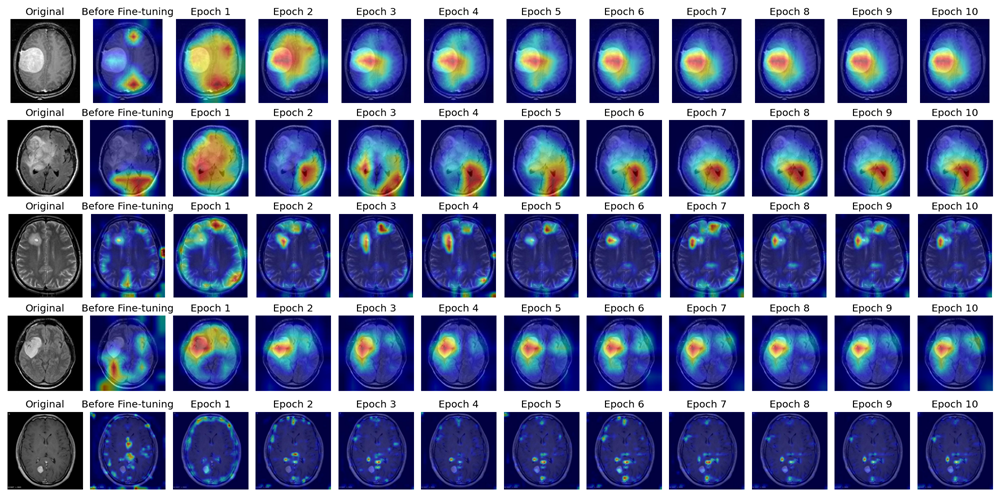

## Introduction
In this notebook, I will build a deep learning model aimed at classifying MRI scans of human brains. To achieve this, I will use transfer learning with [ResNet](https://arxiv.org/abs/1512.03385). Additionally, I will attempt to add explainability to the model's outputs using [Grad-CAM](https://arxiv.org/abs/1610.02391) (Gradient-weighted Class Activation Mapping), a technique designed to provide a visual explanation of the decision-making processes of deep neural networks via Gradient-based Localization. An important part of this project is the use of transfer learning, primarily due to the scarcity of large datasets in machine learning, especially within the domain of medical imaging. By leveraging pre-trained models, we can streamline the training process and circumvent the need to train all model parameters from scratch. Furthermore, through the explanations provided by Grad-CAM, we will gain a deeper understanding of how the model prioritizes different regions of the brain to detect tumors.

## Goals:
- Gain a deeper understanding of transfer learning and the use of pretrained computer vision models
- Learn more about data augmentation in computer vision
- Classify MRI scans to detect the presence of brain tumors with high accuracy
- Explain model decisions through GradCAM visualization heatmaps

In [1]:
!pip install -q grad-cam

In [2]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import kornia.augmentation as K
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import random
import warnings
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [3]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Loading and Analyzing the Dataset
    </center>
</h1>

In [4]:
tumors_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/'
no_tumors_path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/'

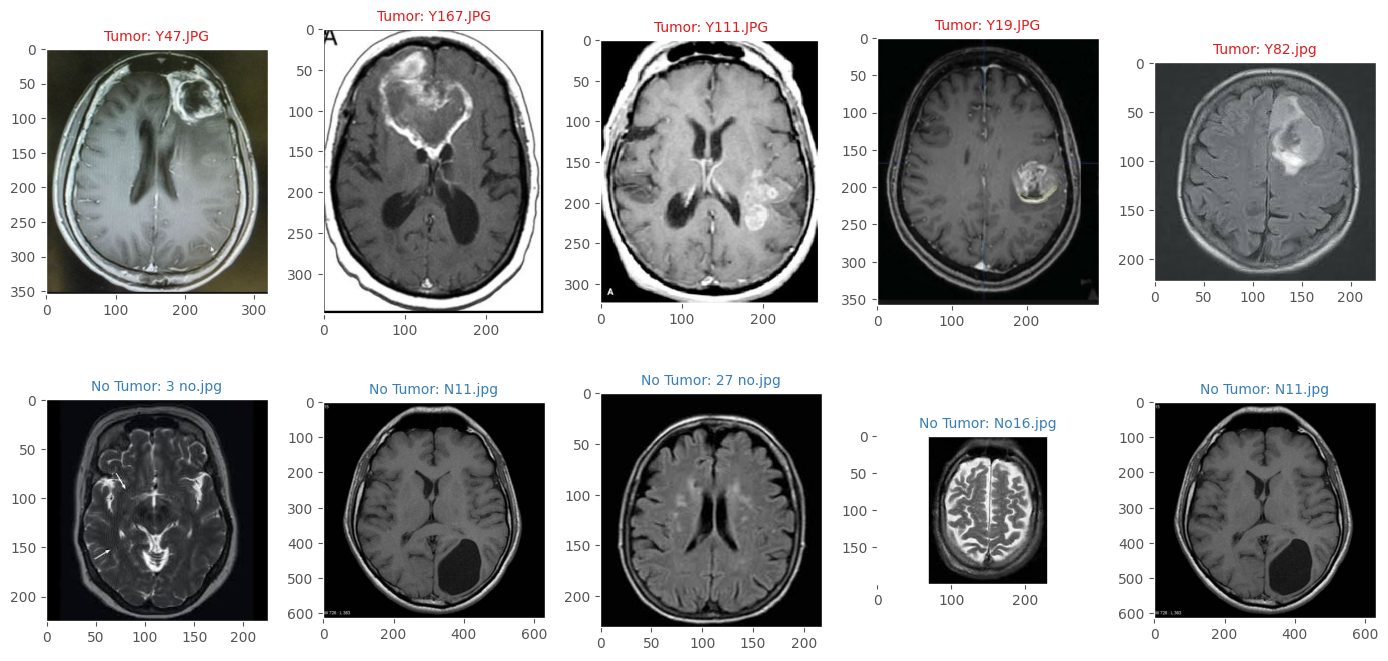

In [5]:
plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 5, figsize=(14, 7))
ax = ax.flatten()

for i in range(5):
    image_file = random.choice(os.listdir(tumors_path))
    image = Image.open(tumors_path + image_file)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'Tumor: {image_file}', color=colors[0], fontsize=10)

for i in range(5, 10):
    image_file = random.choice(os.listdir(no_tumors_path))
    image = Image.open(no_tumors_path + image_file)
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title(f'No Tumor: {image_file}', color=colors[1], fontsize=10)

plt.tight_layout()
plt.show()

Here, I'm displaying a selection of samples from the dataset. The top row showcases MRI scans of brains with tumors, while the bottom row shows MRI scans of healthy brains. Here are some key observations about the dataset:
- The images vary in size, with differing heights and widths.
- The background color of the images varies, ranging from white to black and various shades of dark colors.
- In some images, the brain is not fully captured within the frame, with extreme points being outside the frame.
- Most images in the dataset contain varying degrees of padding.
- Certain images feature a border that contrasts with the background color.

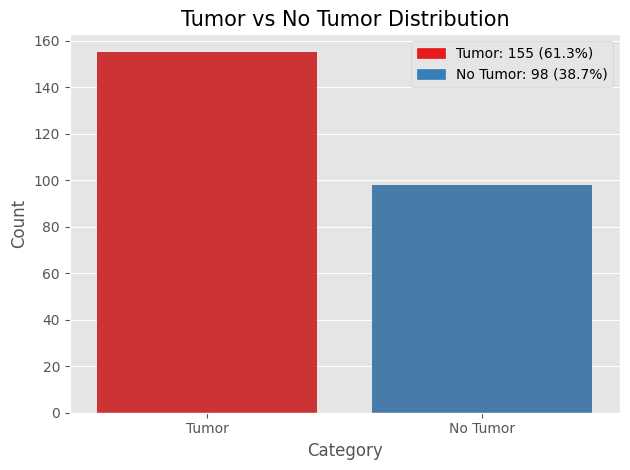

In [6]:
plt.rcParams['axes.grid'] = True

df = pd.DataFrame({
    'Category': ['Tumor', 'No Tumor'],
    'Count': [len(os.listdir(tumors_path)), len(os.listdir(no_tumors_path))]
})
total = df['Count'].sum()
df['Percentage'] = df['Count'] / total * 100

ax = sns.barplot(x='Category', y='Count', data=df, palette=colors)
legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax.legend(handles=patches, title_fontsize='13', loc='best')
plt.title('Tumor vs No Tumor Distribution', fontsize=15)
plt.tight_layout()
plt.show()

- As the figure above shows, this dataset is quite limited in size, having only 253 samples in total. Among these, 155 brain images contain tumors, while 98 do not. This lack of balance in the dataset results in positive samples accounting for approximately 61% of the entire dataset.
- Since I will be using a pretrained model and augment the dataset, the initial dataset size does not matter much.

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Augmenting the Images with Kornia
    </center>
</h1>

In [7]:
augmented_tumors_path = '/kaggle/working/augmented_dataset/yes/'
augmented_no_tumors_path = '/kaggle/working/augmented_dataset/no/'

try:
    os.mkdir('/kaggle/working/augmented_dataset')
    os.mkdir('/kaggle/working/augmented_dataset/yes')
    os.mkdir('/kaggle/working/augmented_dataset/no')
except:
    pass

As previously mentioned, the dataset is quite small, necessitating augmentation to improve model performance. In the upcoming sections, I will detail the procedures for increasing the dataset's size. It's worth mentioning that I won't be balancing the dataset. While generating more augmentations for the minority class might potentially improve the model's performance, I'm content with the final score I achieved. Therefore, I'll refrain from balancing the dataset.

- Here, I make two folders to save the augmented dataset
- I will keep the structure of the original dataset with two subfolders, `yes` and `no`

In [8]:
def generate_augmentations(path: str, augmented_path: str) -> None:
    augmentations = [
        K.RandomHorizontalFlip(p=1.0),
        K.RandomVerticalFlip(p=1.0),        
        K.RandomRotation(degrees=15, p=1.0),
        K.RandomAffine(degrees=15, p=1.0),
        K.RandomElasticTransform(p=1.0),
        K.RandomGaussianBlur(kernel_size=(5, 9), p=1.0, sigma=(0.1, 5.0)),
        K.RandomSharpness(p=1.0),
    ]

    for image in os.listdir(path):
        # Reading the image into PIL format
        img = Image.open(path + image).convert('L')
        
        file_extension = image.split('.')[1]
        file_name = image.split('.')[0].replace(' ', '-')
        
        # Saving the original image
        img.save(f'{augmented_path}{file_name}_Original.{file_extension}')
        
        # Convertering th PIL image to tensor to apply augmentations to it
        img = transforms.ToTensor()(img)
        for aug in augmentations:
            augmented = aug(img)
            augmented = augmented.squeeze(0)
            augmented = augmented.squeeze(0)
            
            # Convertering the tensor image back to PIL image and saving
            augmented = transforms.ToPILImage()(augmented)
            augmented.save(f'{augmented_path}{file_name}_{aug.__class__.__name__}.{file_extension}')
    

generate_augmentations(tumors_path, augmented_tumors_path)
generate_augmentations(no_tumors_path, augmented_no_tumors_path)

print('Original dataset size: ', len(os.listdir(tumors_path)) + len(os.listdir(no_tumors_path)))
print('Augmented dataset size: ', len(os.listdir(augmented_tumors_path)) + len(os.listdir(augmented_no_tumors_path)))

Original dataset size:  253
Augmented dataset size:  2024


- I'm applying the following 7 augmentations to each image, I'm also keeping the original image.

```python
K.RandomHorizontalFlip(p=1.0)
K.RandomVerticalFlip(p=1.0)       
K.RandomRotation(degrees=15, p=1.0
K.RandomAffine(degrees=15, p=1.0)
K.RandomElasticTransform(p=1.0)
K.RandomGaussianBlur(kernel_size=(5, 9), p=1.0, sigma=(0.1, 5.0))
K.RandomSharpness(p=1.0)
```

- Every augmentation is applied with a probability of 1, since I want every augmentation to be applied to every image
- `RandomHorizontalFlip`, `RandomVerticalFlip`, `RandomRotation`, `RandomAffine`, and `RandomElasticTransform` are geometric augmentations that modify the spatial characteristics of the images.
- `RandomGaussianBlur`, and `RandomSharpness` are intensity augmentations that adjust the pixel values within the images. The former applies random Gaussian blurring to the image, smoothing out details. And the latter, adjusts the sharpness of the image, enhancing image details

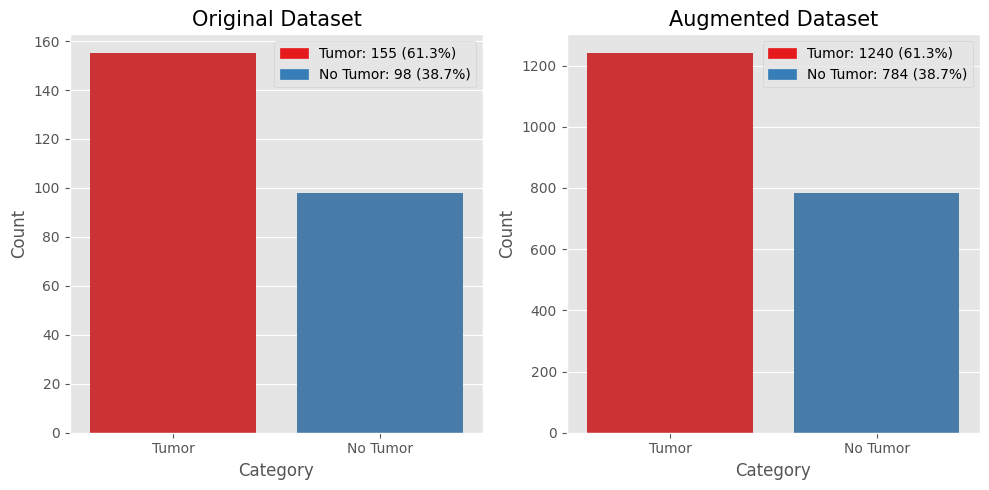

In [9]:
df = pd.DataFrame({
    'Category': ['Tumor', 'No Tumor'],
    'Count': [len(os.listdir(tumors_path)), len(os.listdir(no_tumors_path))]
})
total = df['Count'].sum()
df['Percentage'] = df['Count'] / total * 100

df_augmented = pd.DataFrame({
    'Category': ['Tumor', 'No Tumor'],
    'Count': [len(os.listdir(augmented_tumors_path)), len(os.listdir(augmented_no_tumors_path))]
})
total_augmented = df_augmented['Count'].sum()
df_augmented['Percentage'] = df_augmented['Count'] / total_augmented * 100

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x='Category', y='Count', data=df, palette=colors, ax=ax[0])
sns.barplot(x='Category', y='Count', data=df_augmented, palette=colors, ax=ax[1])

legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax[0].legend(handles=patches, title_fontsize='13', loc='best')
ax[0].set_title('Original Dataset', fontsize=15)

legend_labels = [f'{row.Category}: {row.Count} ({row.Percentage:.1f}%)' for _, row in df_augmented.iterrows()]
patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
ax[1].legend(handles=patches, title_fontsize='13', loc='best')
ax[1].set_title('Augmented Dataset', fontsize=15)

plt.tight_layout()
plt.show()

- As the figure above shows, the augmentations applied in the previous step has increased the size of the dataset by 8 fold and the ratio of labels is preserved
- The plots below show a sample image and how each augmentation has affected the original image

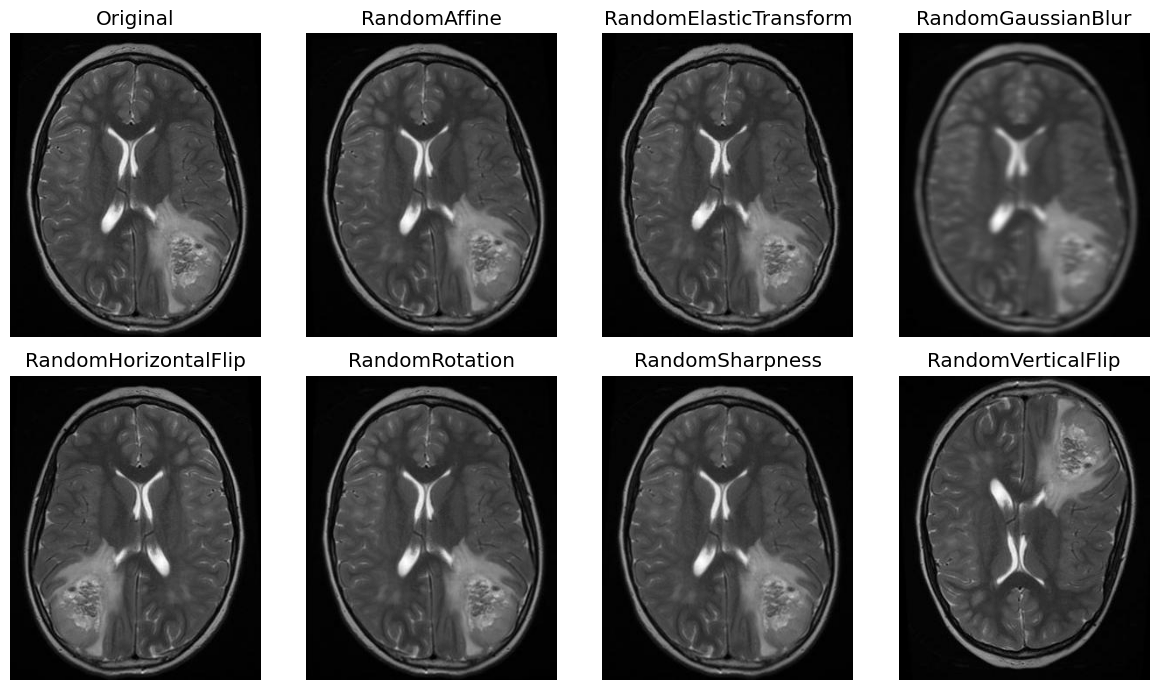

In [10]:
samples = [
    augmented_tumors_path + 'Y100_Original.JPG',
    augmented_tumors_path + 'Y100_RandomAffine.JPG',
    augmented_tumors_path + 'Y100_RandomElasticTransform.JPG',
    augmented_tumors_path + 'Y100_RandomGaussianBlur.JPG',
    augmented_tumors_path + 'Y100_RandomHorizontalFlip.JPG',
    augmented_tumors_path + 'Y100_RandomRotation.JPG',
    augmented_tumors_path + 'Y100_RandomSharpness.JPG',
    augmented_tumors_path + 'Y100_RandomVerticalFlip.JPG',
]

fig, axs = plt.subplots(2, 4, figsize=(12, 7))
start_index = 0
for row in range(2):
    for col in range(4):
        filename = Image.open(samples[start_index])
        aug_type = filename.filename.split('/')[-1].split('_')[-1].split('.')[0]
        axs[row, col].imshow(filename, cmap='gray')
        axs[row, col].set_title(aug_type)
        axs[row, col].axis('off')
        start_index += 1

plt.tight_layout()
plt.show()

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Splitting the Augmented Dataset into Train, Validation, and Test Sets
    </center>
</h1>

In [11]:
def create_directory(path: str) -> None:
    try:
        os.makedirs(path)
    except FileExistsError:
        pass


def split_data(data: list, train_ratio: float = 0.8, val_ratio: float = 0.1) -> Tuple[list, list, list]:
    np.random.shuffle(data)
    train_end = int(len(data) * train_ratio)
    val_end = int(len(data) * (train_ratio + val_ratio))
    return data[:train_end], data[train_end:val_end], data[val_end:]


def save_images(data: list, source_dir: str, target_dir: str) -> None:
    for filename in data:
        img = Image.open(os.path.join(source_dir, filename))
        img.save(os.path.join(target_dir, filename))


dataset_dirs = [
    '/kaggle/working/dataset/train/yes',
    '/kaggle/working/dataset/train/no',
    '/kaggle/working/dataset/val/yes',
    '/kaggle/working/dataset/val/no',
    '/kaggle/working/dataset/test/yes',
    '/kaggle/working/dataset/test/no'
]

for dir_path in dataset_dirs:
    create_directory(dir_path)

tumors = os.listdir(augmented_tumors_path)
no_tumors = os.listdir(augmented_no_tumors_path)

tumors_train, tumors_val, tumors_test = split_data(tumors)
no_tumors_train, no_tumors_val, no_tumors_test = split_data(no_tumors)

save_images(tumors_train, augmented_tumors_path, '/kaggle/working/dataset/train/yes')
save_images(tumors_val, augmented_tumors_path, '/kaggle/working/dataset/val/yes')
save_images(tumors_test, augmented_tumors_path, '/kaggle/working/dataset/test/yes')

save_images(no_tumors_train, augmented_no_tumors_path, '/kaggle/working/dataset/train/no')
save_images(no_tumors_val, augmented_no_tumors_path, '/kaggle/working/dataset/val/no')
save_images(no_tumors_test, augmented_no_tumors_path, '/kaggle/working/dataset/test/no')

- I'm using a 80-10-10 ratio to split the dataset into training, validation, and test sets
- Since I'm creating the dataset with `ImageFolder` from torchvision, the folder structure is important. Therefore, I'm creating a structure that looks something like the tree structure below.

```
├───dataset
│   ├───test
│   │   ├───no
│   │   └───yes
│   ├───train
│   │   ├───no
│   │   └───yes
│   └───val
│       ├───no
│       └───yes
```

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Creating Datasets and Dataloaders for Training
    </center>
</h1>

In [12]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_dir = 'dataset'

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.2470, 0.2470, 0.2470], [0.2364, 0.2364, 0.2364])
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- The code snippet above is directly adapted from the official PyTorch tutorial for fine-tuning ResNet, with a few modifications.
- I have resized the images to `224x224` since ResNet is pretrained on images of this size.
- I have applied normalization to the training data using mean values of `[0.2470, 0.2470, 0.2470]` and standard deviations of `[0.2364, 0.2364, 0.2364]`. These values are calculated with the function provided below.

```python
def find_mean_std(loader: DataLoader) -> Tuple[torch.Tensor, torch.Tensor]:
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

mean, std = find_mean_std(dataloaders['train'])
print('Mean: ', mean)
print('Std: ', std)
```

- Note that to run this code, you need to comment out the normalization in `data_transforms`, execute the code to create the dataloaders, and then use the dataloader to compute the mean and standard deviation. Afterward, you can recreate the dataloaders, uncomment the normalization, and apply the output from the function.

In [13]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None
        
    def save_cam_samples(self, model: models.resnet.ResNet, epoch_nr: int) -> None:
        samples = [
            'samples/Y1.jpg',
            'samples/Y2.jpg',
            'samples/Y3.jpg',
            'samples/Y4.jpg',
            'samples/Y6.jpg'
        ]

        targets = [1, 1, 1, 1, 1]
        
        target_layer = [model.layer4[-1]]
        cam = GradCAM(model=model, target_layers=target_layer)

        plt.rcParams['axes.grid'] = False

        for i, (image_path, target) in enumerate(zip(samples, targets)):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transforms.ToTensor()(image).unsqueeze(0)
            
            image = transforms.ToTensor()(image)
            image = image.numpy().transpose((1, 2, 0))
            image = np.clip(image, 0, 1)
            
            targets = [ClassifierOutputTarget(target)]
            grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

            filename = image_path.split('/')[-1].split('.')[0]
            filetype = image_path.split('/')[-1].split('.')[1]
            plt.imshow(visualization)
            plt.axis('off') 
            plt.savefig(f'samples/{filename}-cam-epoch-{epoch_nr}.{filetype}', bbox_inches='tight', pad_inches=0)
            plt.close()

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        if current_epoch_nr == 1:
            self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))
            
        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f'epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth'
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, list, list, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0
        
        targets = []
        predictions = []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)
                
                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches
        
        print('\nTest Accuracy: ', test_accuracy)
        print('Test Loss: ', test_loss)

        self.model.load_state_dict(torch.load(self.best_model_path))
        
        return test_accuracy, test_loss, targets, predictions, self.model
    
# I will use these samples to visualize CAM results
samples = [
    tumors_path + 'Y1.jpg',
    tumors_path + 'Y2.jpg',
    tumors_path + 'Y3.jpg',
    tumors_path + 'Y4.jpg',
    tumors_path + 'Y6.jpg',
]
os.makedirs('samples', exist_ok=True)
for sample in samples:
    img = Image.open(sample)
    img.save('samples/' + sample.split('/')[-1])

- Creating a training script with PyTorch can be a bit complex, but IMO it offers greater flexibility compared to frameworks like Keras and PyTorch Lightning.
- Since the trainer code is long and not very interesting, I have decided to hide the cell. However, feel free to explore the script if you are interested.
- It's worth mentioning that at the end of the training, during testing, I'm loading the best model checkpoint and returning it to be used by Grad-CAM.

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Training
    </center>
</h1>

In [14]:
model = models.resnet50(weights='IMAGENET1K_V2')
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [15]:
max_epochs = 10

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = '/kaggle/working/checkpoints'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, targets, predictions, best_model = trainer.test()

Testing: 100%|██████████| 13/13 [00:00<00:00, 15.03it/s, test_acc=0.995, test_loss=0.0188]



Test Accuracy:  0.9950738916256158
Test Loss:  0.29397107689426494


<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Analyzing the Results
    </center>
</h1>

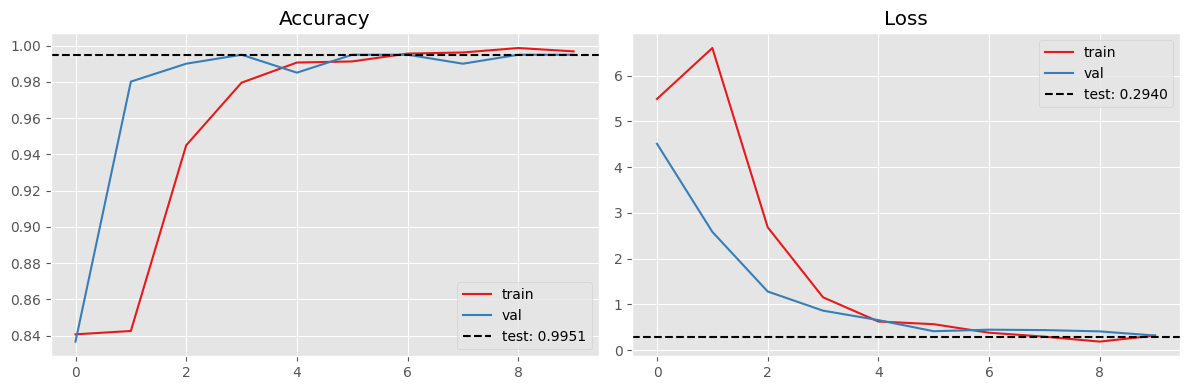

In [16]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

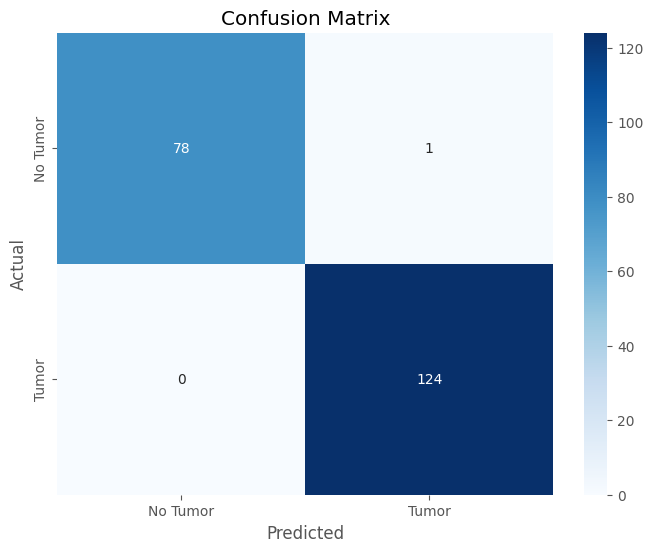

In [17]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print(classification_report(targets, predictions, target_names=['No Tumor', 'Tumor']))

              precision    recall  f1-score   support

    No Tumor       1.00      0.99      0.99        79
       Tumor       0.99      1.00      1.00       124

    accuracy                           1.00       203
   macro avg       1.00      0.99      0.99       203
weighted avg       1.00      1.00      1.00       203



<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Model Explanation with GradCAM
    </center>
</h1>

In [19]:
def plot_cam(model: models.resnet.ResNet, image_paths: list, targets: list) -> None:
    model = model.eval()
    
    target_layer = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image = transforms.ToTensor()(image)
        
        image_tensor = image.unsqueeze(0)
        
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')

    plt.tight_layout()
    plt.show()

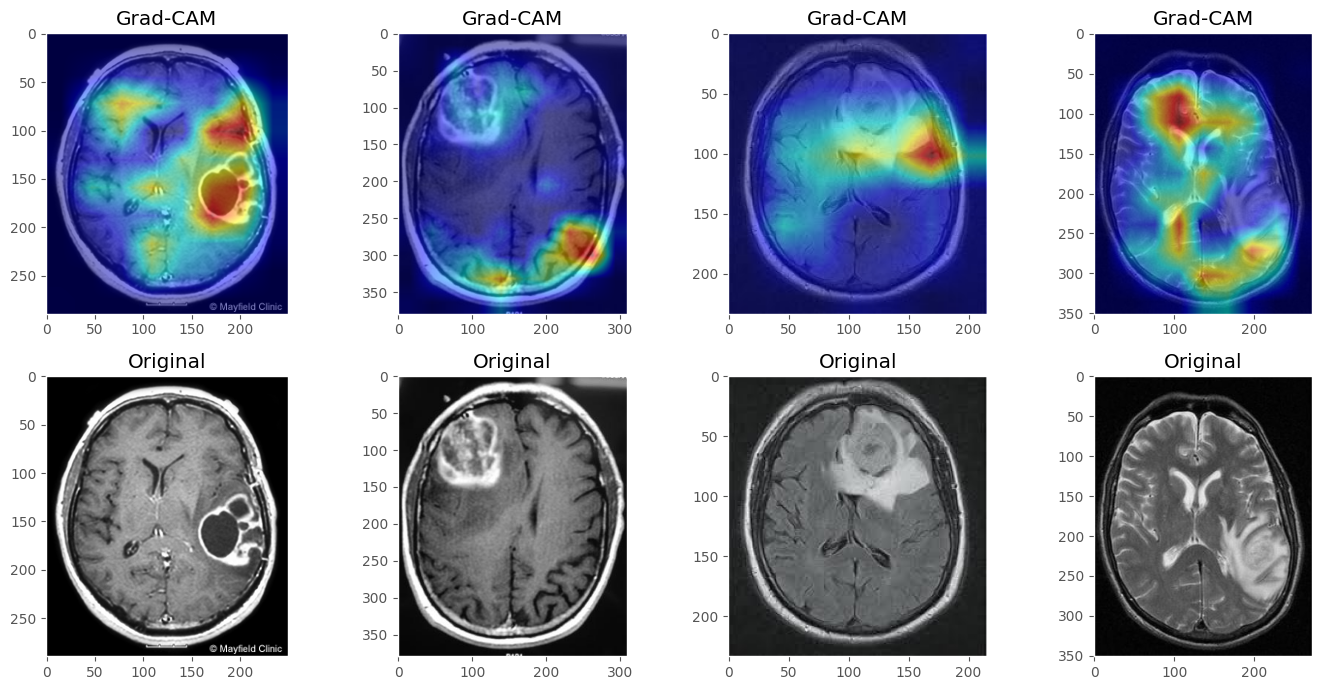

In [20]:
image_paths = [os.path.join(tumors_path, filename) for filename in os.listdir(tumors_path)][24:28]
plot_cam(best_model, image_paths, [1] * 4)

- The figures above display five selected brain images containing tumors, which have undergone Grad-CAM analysis.
- The bottom row shows the original images, while the top row showcases the CAM visualizations. These visualizations highlight specific regions within the images that the model focuses on for tumor detection.
- Additionally, we can observe the model's training progression, indicating its efficacy in tumor detection over time. Below, I have plotted the original image, the Grad-CAM heatmap before fine-tuning (i.e., ResNet without additional training), and the evolution of the heatmap throughout 10 epochs of training. This clearly illustrates the model's improving ability to localize tumors within the images.

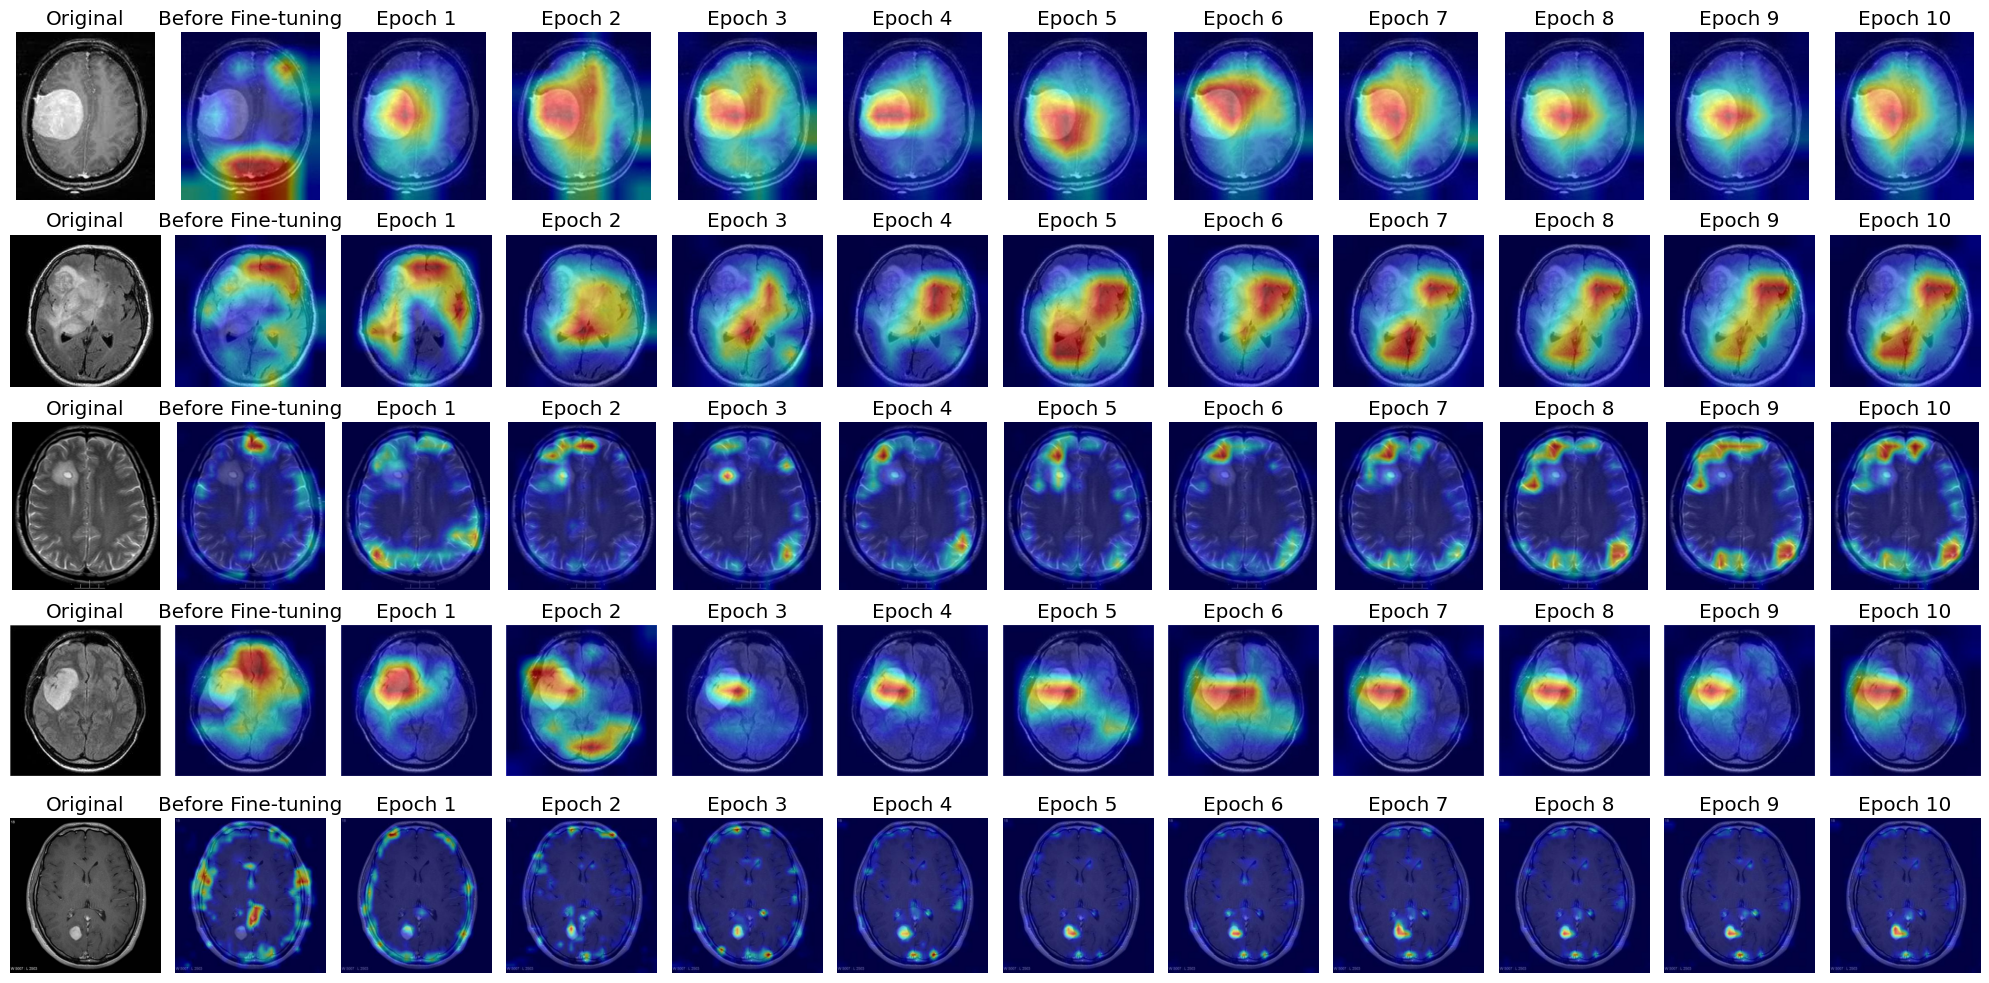

In [21]:
samples = [
    '/kaggle/working/samples/Y1.jpg',
    '/kaggle/working/samples/Y2.jpg',
    '/kaggle/working/samples/Y3.jpg',
    '/kaggle/working/samples/Y4.jpg',
    '/kaggle/working/samples/Y6.jpg'
]

fig, axs = plt.subplots(len(samples), max_epochs + 2, figsize=(20, 10))
start_index = 0
for row in range(len(samples)):
    filename = Image.open(samples[start_index])
    axs[row, 0].imshow(filename, cmap='gray')
    axs[row, 0].set_title('Original')
    axs[row, 0].axis('off')
    start_index += 1

    original_filename = filename.filename.split("/")[-1].split(".")[0]

    for col in range(1, max_epochs + 2):
        filename = Image.open(f'samples/{original_filename}-cam-epoch-{col-1}.jpg')
        axs[row, col].imshow(filename, cmap='gray')
        if col == 0:
            title = "Original"
        if col == 1:
            title = "Before Fine-tuning"
        if col > 1:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title)
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        Conclusion
    </center>
</h1>

- I have demonstrated the effectiveness of transfer learning in fine-tuning ResNet to achieve high accuracy on an unseen dataset, significantly reducing training time, while improving prediction accuracy.
- The final model achieved an impressive accuracy of `99.74%` on the test dataset. Notably, the confusion matrix revealed only one false negative prediction, indicating a near-perfect accuracy of `100%`.
- The Grad-CAM visualizations illustrate the focal points of the model's attention during prediction tasks. Furthermore, I've provided insights into the evolution of model performance by showcasing Grad-CAM heatmaps throughout the training process, demonstrating the model's predictive capabilities over time.

<h1 id="analyzing-the-results" style="font-family:verdana;"> 
    <center>
        References
    </center>
</h1>

- [Advanced AI explainability for PyTorch](https://github.com/jacobgil/pytorch-grad-cam)
- [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)